## Данные

Скачиваются по [ссылке](https://drive.google.com/open?id=1gJEpwM3zdV5xe9nRU0VwQmGTiOTQdp10). Это отзывы пользователей на фильмы с КиноПоиска.

In [1]:
import pandas as pd

In [2]:
df = pd.read_csv('reviews.csv')

In [12]:
df.head()

,label,text
0,1,Эпиграф Добро которое ты делаешь от сердца ты ...
1,1,Теперь это один из моих любимых фильмов в жанр...
2,1,Что скрыто в фильме Лучше не бывает Одна шикар...
3,1,Перед нами очень милое и доброе кино которое л...
4,1,Завязка Мелвин Удал популярный писатель Нет не...


In [4]:
set(df.label)

{-1, 0, 1}

## Baseline

In [3]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

In [6]:
vec = CountVectorizer()
bag_of_words = vec.fit_transform(df.text)
X_train, X_test, y_train, y_test = train_test_split(bag_of_words, df.label)

In [7]:
nb = MultinomialNB()
clf = nb.fit(X_train, y_train)

In [4]:
from sklearn.metrics import classification_report

In [9]:
print(classification_report(y_test, clf.predict(X_test)))

              precision    recall  f1-score   support

          -1       0.70      0.22      0.34      1112
           0       0.34      0.07      0.12      1395
           1       0.82      0.98      0.89      9119

    accuracy                           0.80     11626
   macro avg       0.62      0.43      0.45     11626
weighted avg       0.75      0.80      0.75     11626



### Лемматизируем тексты с правильной токенизацией

In [5]:
from nltk import word_tokenize
import pymorphy2
morph_analyzer = pymorphy2.MorphAnalyzer()

def lemmatize(text):
    words = word_tokenize(text)
    lemmas = [morph_analyzer.parse(word)[0].normal_form for word in words] 
    return ' '.join(lemmas)

In [13]:
df['text_lemmatized'] = df['text'].apply(lemmatize)

### Проверим, повлияла ли предобработка на результат

In [9]:
vec = CountVectorizer()
bow = vec.fit_transform(df.text_lemmatized)
X_train, X_test, y_train, y_test = train_test_split(bow, df.label)

nb = MultinomialNB()
clf = nb.fit(X_train, y_train)

print(classification_report(y_test, clf.predict(X_test)))

              precision    recall  f1-score   support

          -1       0.58      0.51      0.55      1104
           0       0.34      0.22      0.27      1485
           1       0.87      0.93      0.90      9037

    accuracy                           0.80     11626
   macro avg       0.60      0.56      0.57     11626
weighted avg       0.77      0.80      0.78     11626



Результат в целом улучшился, но у отрицательных отзывов, которых в корпусе мало, упала точность. Попробуем добавить другие способы предобработки.

### Уберем стоп-слова и пунктуацию

In [10]:
from nltk.corpus import stopwords
from string import punctuation

noise = stopwords.words('russian') + list(punctuation)

vec = CountVectorizer(stop_words=noise)
bow = vec.fit_transform(df.text_lemmatized)
X_train, X_test, y_train, y_test = train_test_split(bow, df.label)

nb = MultinomialNB()
clf = nb.fit(X_train, y_train)

print(classification_report(y_test, clf.predict(X_test)))

              precision    recall  f1-score   support

          -1       0.61      0.49      0.54      1101
           0       0.33      0.24      0.28      1398
           1       0.87      0.93      0.90      9127

    accuracy                           0.81     11626
   macro avg       0.60      0.56      0.58     11626
weighted avg       0.78      0.81      0.79     11626



F-мера и точность выросли и по сравнению с предыдущим вариантом, и по сравнению с baseline, но точность для негативных отзывов все еще низкая. Также немного снизилась точность для нейтральных отзывов. Посмотрим, что будет, если убрать только пунктуацию или только стоп-слова.

### Убираем только стоп-слова

In [25]:
noise = stopwords.words('russian')

vec = CountVectorizer(stop_words=noise)
bow = vec.fit_transform(df.text_lemmatized)
X_train, X_test, y_train, y_test = train_test_split(bow, df.label)

nb = MultinomialNB()
clf = nb.fit(X_train, y_train)

print(classification_report(y_test, clf.predict(X_test)))

              precision    recall  f1-score   support

          -1       0.61      0.51      0.55      1060
           0       0.34      0.21      0.26      1415
           1       0.87      0.94      0.90      9151

    accuracy                           0.81     11626
   macro avg       0.60      0.55      0.57     11626
weighted avg       0.78      0.81      0.79     11626



### Убираем только пунктуацию

In [31]:
noise = list(punctuation)

vec = CountVectorizer(stop_words=noise)
bow = vec.fit_transform(df.text_lemmatized)
X_train, X_test, y_train, y_test = train_test_split(bow, df.label)

nb = MultinomialNB()
clf = nb.fit(X_train, y_train)

print(classification_report(y_test, clf.predict(X_test)))

              precision    recall  f1-score   support

          -1       0.61      0.51      0.56      1103
           0       0.34      0.26      0.29      1352
           1       0.88      0.93      0.91      9171

    accuracy                           0.81     11626
   macro avg       0.61      0.57      0.59     11626
weighted avg       0.79      0.81      0.80     11626



Кажется, стоп-слова лучше не убирать.

### Попробуем другие классификаторы

In [15]:
from sklearn.linear_model import LogisticRegression

In [10]:
noise = list(punctuation)

vec = CountVectorizer(stop_words=noise)
bow = vec.fit_transform(df.text_lemmatized)
X_train, X_test, y_train, y_test = train_test_split(bow, df.label)

lr = LogisticRegression()
clf = lr.fit(X_train, y_train)

print(classification_report(y_test, clf.predict(X_test)))

C:\Users\User\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


              precision    recall  f1-score   support

          -1       0.62      0.55      0.59      1065
           0       0.36      0.28      0.32      1408
           1       0.89      0.93      0.91      9153

    accuracy                           0.82     11626
   macro avg       0.63      0.59      0.61     11626
weighted avg       0.80      0.82      0.81     11626



Логистическая регрессия справляется явно лучше, чем Наивный Байес. Что, если мы возьмем логистическую регрессию с TF-IDF векторизатором?

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [23]:
noise = list(punctuation)

vec = TfidfVectorizer(min_df=1, max_df=0.99, stop_words=noise)
bow = vec.fit_transform(df.text_lemmatized)
X_train, X_test, y_train, y_test = train_test_split(bow, df.label)

lr = LogisticRegression()
clf = lr.fit(X_train, y_train)

print(classification_report(y_test, clf.predict(X_test)))

C:\Users\User\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


              precision    recall  f1-score   support

          -1       0.74      0.46      0.57      1047
           0       0.56      0.11      0.18      1414
           1       0.85      0.99      0.91      9165

    accuracy                           0.84     11626
   macro avg       0.71      0.52      0.55     11626
weighted avg       0.80      0.84      0.79     11626



Даже при крайних значениях max_df, min_df F-мера падает из-за низкого показателя полноты для нейтральных отзывов. Видимо, частые слова, которые выкидывает TF-IDF, являются характерными именно для нейтральных отзывов, т.к. эмоционально окрашенных слов, которые встречаются редко и характеризуют позитивные и негативные отзывы, в нейтральных отзывах мало. По этой же причине TF-IDF точнее определяет негативные отзывы. 

Оставим CountVectorizer, но попробуем поменять гиперпараметры модели.

In [10]:
from sklearn.model_selection import GridSearchCV

In [26]:
grid_values = {'penalty': ['l1', 'l2'],'C':[0.001,.009,0.01,.09,1,5,10,25]}
grid_clf_acc = GridSearchCV(clf, param_grid = grid_values)
grid_clf_acc.fit(X_train, y_train)

C:\Users\User\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=LogisticRegression(C=1.0, class_weight=None, dual=False,
                                          fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=100, multi_class='warn',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='warn',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'C': [0.001, 0.009, 0.01, 0.09, 1, 5, 10, 25],
                         'penalty': ['l1', 'l2']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [27]:
noise = list(punctuation)

vec = CountVectorizer(stop_words=noise)
bow = vec.fit_transform(df.text_lemmatized)
X_train, X_test, y_train, y_test = train_test_split(bow, df.label)

lr = LogisticRegression(C=1, penalty='l2')
clf = lr.fit(X_train, y_train)

print(classification_report(y_test, clf.predict(X_test)))

C:\Users\User\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


              precision    recall  f1-score   support

          -1       0.64      0.57      0.60      1094
           0       0.36      0.26      0.30      1424
           1       0.89      0.94      0.91      9108

    accuracy                           0.82     11626
   macro avg       0.63      0.59      0.60     11626
weighted avg       0.80      0.82      0.81     11626



Ощутимых улучшений по сравнению с моделью без регуляризации нет.

### Попробуем kNN

In [7]:
from sklearn.neighbors import KNeighborsClassifier

In [9]:
noise = list(punctuation)
vec = CountVectorizer(stop_words=noise)
bow = vec.fit_transform(df.text_lemmatized)
X_train, X_test, y_train, y_test = train_test_split(bow, df.label)

knn = KNeighborsClassifier()
clf = knn.fit(X_train, y_train)
print(classification_report(y_test, clf.predict(X_test)))

              precision    recall  f1-score   support

          -1       0.32      0.08      0.13      1088
           0       0.19      0.09      0.12      1405
           1       0.80      0.94      0.87      9133

    accuracy                           0.76     11626
   macro avg       0.44      0.37      0.37     11626
weighted avg       0.68      0.76      0.71     11626



С дефолтными параметрами kNN работает хуже логистической регрессии. Попробуем подобрать другое число соседей.

In [11]:
grid_values = {'n_neighbors': list(range(1, 8))}
grid_clf_acc = GridSearchCV(clf, param_grid = grid_values)
grid_clf_acc.fit(X_train, y_train)

C:\Users\User\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


GridSearchCV(cv='warn', error_score='raise-deprecating',
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='warn', n_jobs=None,
             param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

Оказывается, дефолтное значение n_neighbors было оптимальным.

### Попробуем дерево решений

In [12]:
from sklearn.tree import DecisionTreeClassifier

In [13]:
decision_tree = DecisionTreeClassifier()
clf = decision_tree.fit(X_train, y_train)
print(classification_report(y_test, clf.predict(X_test)))

              precision    recall  f1-score   support

          -1       0.24      0.22      0.23      1088
           0       0.19      0.17      0.18      1405
           1       0.83      0.85      0.84      9133

    accuracy                           0.71     11626
   macro avg       0.42      0.41      0.42     11626
weighted avg       0.70      0.71      0.70     11626



Дерево решений тоже не помогло побить baseline. 

В целом, baseline удается побить разными видами предобработки и использованием логистической регрессии. Дерево решений и kNN с задачей не справились. 

**Лучший результат показала логистическая регрессия на лемматизированных текстах, векторизованных с помощью CountVectorizer, без пунктуации.** 

Посмотрим, какие веса были у этой модели.

In [16]:
lr = LogisticRegression()
clf = lr.fit(X_train, y_train)

print(classification_report(y_test, clf.predict(X_test)))

C:\Users\User\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


              precision    recall  f1-score   support

          -1       0.63      0.54      0.58      1088
           0       0.35      0.27      0.30      1405
           1       0.89      0.93      0.91      9133

    accuracy                           0.82     11626
   macro avg       0.62      0.58      0.60     11626
weighted avg       0.80      0.82      0.81     11626



In [33]:
top_features = sorted(enumerate(clf.coef_[0]), key=lambda pair: pair[1], reverse=True)[:20]
indx_to_word = {indx: word for word, indx in vec.vocabulary_.items()}

In [34]:
word_to_num = {}
for top_feature in top_features:
    print(indx_to_word[top_feature[0]])
    word_to_num[indx_to_word[top_feature[0]]] = top_feature[1]

бредовый
фальшивый
обидный
скучно
разочаровать
толерантность
унылый
невнятный
самолюбие
пропаганда
разочарование
скучный
союзник
пародия
потратить
приквёлый
видимо
потуга
неудачный
отвратительный


### Топ-20 признаков по значимости

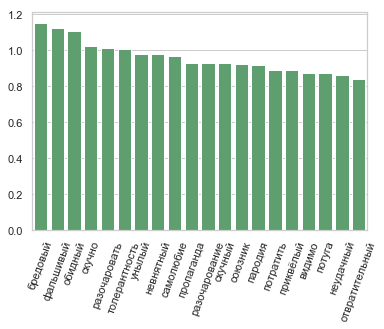

In [51]:
import seaborn as sns

plot = sns.barplot(list(word_to_num.keys()), list(word_to_num.values()), color = 'g')
for item in plot.get_xticklabels():
    item.set_rotation(70)

Интересно, что в топе самых значимых признаков оказалось много негативно окрашенных слов. Здесь есть еще и нейтральные слова (например, "видимо"), которые мы изначально отнесли к числу стоп-слов (тогда логично, что удаление стоп-слов ухудшило результаты).

### Посмотрим на confusion matrix

In [54]:
from sklearn.metrics import confusion_matrix

C:\Users\User\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\User\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


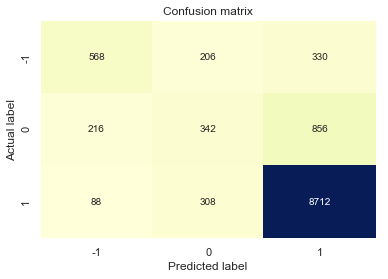

In [83]:
y_pred_lemm = clf.fit(X_train, y_train).predict(X_test)

def plot_confusion_matrix(y_pred, title):
    categories = ['-1', '0', '1']
    sns.heatmap(data=confusion_matrix(y_test, y_pred), cmap="YlGnBu",
                annot=True, fmt="d", cbar=False, xticklabels=categories, yticklabels=categories)
    plt.title(title)
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    plt.show()


plot_confusion_matrix(y_pred_lemm, 'Confusion matrix') 

По этой визуализации заметна проблема модели: позитивные отзывы часто путаются с нейтральными.

+См. визуализацию признаков чуть выше.